In [5]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
from ParticlePlotFunctions import *
import matplotlib.animation as animation
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# load bathymetry and land mask, land=0, ocean=1

bathy_file = '/home/sypmauu/GalapagosNEMO/data/RGEMS3_Surf_grid.nc'
dfile = Dataset(bathy_file)
bathy = dfile.variables['Depth'][:]
lat = dfile.variables['YG'][:]
lon = dfile.variables['XG'][:]

landmask = bathy[:]
landmask = np.where(landmask<1, 0, landmask)
landmask = np.where(landmask>=1, 1, landmask)
bathy = np.where(bathy<1, nan, bathy)


In [7]:
# load particle data
namefile = '../../data/galapagosparticles_bwd_4km_2008.nc'
Traj = ReadTrajectories(namefile)


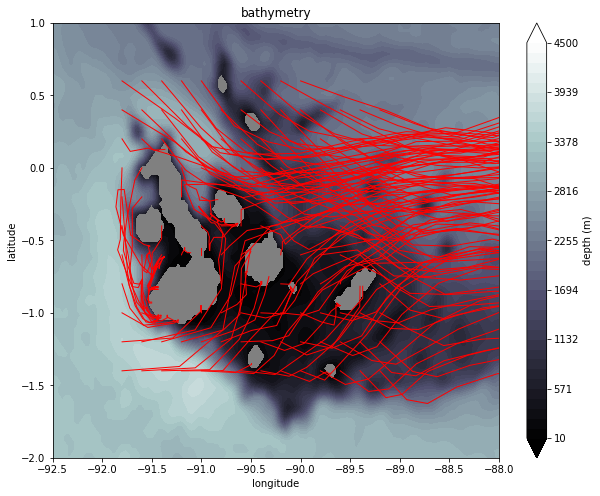

In [15]:
#quick check output

plat = Traj['lat'][0:150,0:200]
plon = Traj['lon'][0:150,0:200]
map_extent = [-92.5,-88,-2,1]
figsize=(10,8)
PlotBathyTraj(plon,plat,lon,lat,bathy,figsize,map_extent)
plt.savefig('../../results/figures/MITgcm_resolution_parcels.pdf')

In [8]:
# Make histogram, number of particles per gridbox, no double counting

plat = Traj['lat'][:]
plon = Traj['lon'][:]

bins = [np.arange(-97,-74, 1), np.arange(-10, 11, 1)]
pmap = np.zeros([len(bins[0])-1,len(bins[1])-1], dtype=float)

for particle in range (len(plon)):
    plonn = plon[particle,:]
    platt = plat[particle,:]
    H, xe, ye = np.histogram2d(plonn[~isnan(plonn)],platt[~np.isnan(platt)], bins=bins)
    H[H > 0]=1
    pmap += H    

pmap=pmap/len(plon)

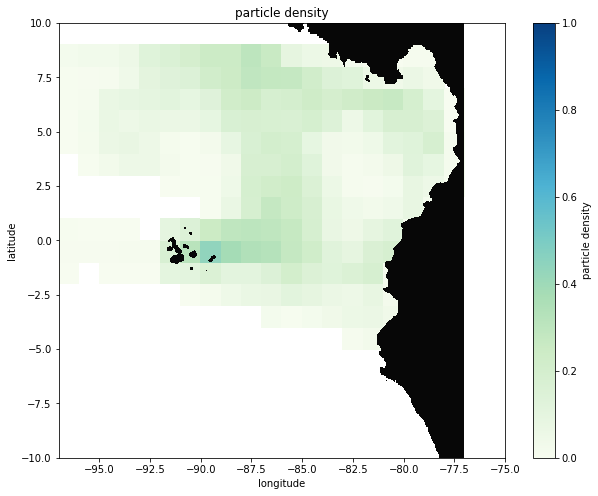

In [9]:
# Make plot with histogram and mask land
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)

vmax = 1
pmap[pmap==0]=nan
fig1 = ax.pcolor(bins[0][:-1],bins[1][:-1],pmap.T,           
                   cmap='GnBu',
                   vmin=0,
                   vmax=vmax)    
ax.set_title('particle density')          
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
cbar = plt.colorbar(fig1, ax=ax)
cbar.ax.set_ylabel('particle density')

landmask=landmask*1.0
landmask[landmask==1]=nan
levels = np.linspace(0, 1, 20)
fig2 = ax.contourf(lon, lat, landmask, cmap='Greys_r', levels=levels)
ax.set_xlim(bins[0][0],bins[0][-1])
ax.set_ylim(bins[1][0],bins[1][-1])
plt.savefig('../../results/figures/MITgcm_parcelsdensity_dec2008.pdf')

# old

In [ ]:
#find which particles arrived at the Galapagos islands
Traj['traveltime'] = [] #age at arrival
Traj['visittime'] = []  #date of arrival
Traj['pvisited'] = []   #index particle
Traj['tvisited'] = []   #index time
for p in range(Traj['visitedgalapagos'].shape[0]):               # loop through particles
    if np.any(Traj['visitedgalapagos'][p, :] == 1):              # check whether visited Galapagos
        I = np.where(Traj['visitedgalapagos'][p, :] == 1)[0][0]  # find first index when
        Traj['traveltime'].append(Traj['age'][p, I]/86400.) 
        Traj['visittime'].append(Traj['time'][p,I])
        Traj['pvisited'].append(p)       
        Traj['tvisited'].append(I)
                      

In [ ]:
#individual trajectories that reach Galapagos extent
plat = Traj['lat'][Traj['pvisited'],:]
plon = Traj['lon'][Traj['pvisited'],:]
map_extent = [-180,-70,-30,30]
PlotTrajectories(plon,plat,map_extent)
plt.savefig('../results/figures/TrajAmerica')

In [ ]:
#2D histogram from start to arrival

projection = cartopy.crs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(7,7))
    
grd = ax.gridlines(draw_labels=True,
                   color='gray', 
                   alpha=0.5, 
                   linestyle='--')
grd.xlabels_top = False
grd.ylabels_right = False
grd.xlabel_style = {'size': 15, 'color': 'black'}  
grd.ylabel_style = {'size': 15, 'color': 'black'}
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, facecolor=(160/255, 160/255, 160/255))
ax.set_extent([-130,-60,-25,30]) 

bins = [np.arange(-130,-60, 1), np.arange(-25, 30, 1)]

temp = Traj['lon'][Traj['pvisited'],:]
plon = np.copy(temp)
temp = Traj['lat'][Traj['pvisited'],:]
plat = np.copy(temp)

for i, t in enumerate(Traj['tvisited']):
    plon[i,t:] = nan
    plat[i,t:] = nan

H, xe, ye = np.histogram2d(plon[~np.isnan(plon)], plat[~np.isnan(plat)], bins=bins)
H[0,: ] = H[-1, :]
xb = (xe[1:] + xe[:-1])/2
yb = (ye[1:] + ye[:-1])/2
levels = [10**x for x in range(0, 9)]

co = ax.contourf(xb, yb, H.T, levels=levels, norm=colors.LogNorm())


# Practice plotting
## Subplots


In [ ]:
%matplotlib inline

T = D['bwd_v2']
plat = T['lat']
plon = T['lon']
ptime = T['time']

projection = cartopy.crs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15,15))

for i in range (len(ax)):
    grd = ax[i].gridlines(draw_labels=True,
                          color='gray', 
                          alpha=0.5, 
                          linestyle='--')
    grd.xlabels_top = False
    grd.ylabels_right = False
    if i==1:
        grd.ylabels_left = False
    grd.xlabel_style = {'size': 15, 'color': 'black'}  
    grd.ylabel_style = {'size': 15, 'color': 'black'}
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.LAND, facecolor=(160/255, 160/255, 160/255))
    ax[i].set_extent([-110, -70, -20, 30])    
    
particles = np.arange(1,300)
for particle in particles:
    ax[0].plot(plon[particle,:], plat[particle,:], 
               linewidth=1,
               color='r')

particles = np.arange(40000,40200)
for particle in particles:
    ax[1].plot(plon[particle,:],plat[particle,:])    
    
#plt.show()